# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Homework 5: Trees, Forests, and Boosting

**Harvard University**<br/>
**Summer 2021**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

<hr style="height:2pt">

# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. 

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces only other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

In [3]:
# Load data
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

print(f"{len(data_train)} training observations, {len(data_test)} test observations")
print(data_train.shape[1],"total columns")
print("\nColumns:")
print(', '.join(data_train.columns))

5000 training observations, 5000 test observations
29 total columns

Columns:
lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb, class


In [4]:
display(data_train.head())
display(data_train.describe())

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.884,-0.462,0.196,1.330,1.520,1.040,-1.5200,-1.46,2.17,0.361,-2.030,-0.253,0.00,0.337,-0.597,-0.324,2.55,0.493,1.030,-1.1400,0.0,1.450,0.791,1.400,1.250,0.713,0.812,0.821,1.0
1,0.780,-0.292,0.897,0.384,0.413,1.220,-0.4660,-0.92,0.00,1.100,-1.200,1.080,2.21,0.498,1.490,1.060,0.00,0.493,-0.344,-0.0918,0.0,0.812,0.728,0.975,0.637,0.569,0.777,0.715,1.0
2,0.353,-1.070,-1.740,1.170,-0.199,0.558,0.0574,-1.49,1.09,0.912,-1.080,0.571,0.00,0.781,-0.320,-1.040,2.55,0.616,-1.510,1.5500,0.0,0.829,1.060,0.992,0.825,0.365,0.800,0.766,0.0
3,0.757,0.822,-1.290,0.208,-0.151,1.220,-1.6400,1.53,0.00,1.680,0.189,-0.645,0.00,1.780,0.285,0.520,2.55,1.130,-0.932,0.1170,3.1,4.290,2.420,0.995,0.923,0.927,1.760,1.360,1.0
4,2.040,2.030,-0.472,0.424,-1.500,1.060,0.7980,1.22,2.17,0.805,-0.661,-1.460,0.00,0.885,1.440,0.809,0.00,1.290,0.493,-0.0791,3.1,0.895,0.936,1.030,1.560,1.150,1.120,1.160,1.0


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.986168,0.011449,-0.011057,0.995656,-0.026783,0.990357,0.006779,0.008310,0.999370,0.992922,0.015321,0.010629,1.014648,0.984070,0.017681,-0.012232,0.992122,0.982671,-0.020045,0.017153,0.996650,1.024146,1.023271,1.047602,1.005986,0.972397,1.027461,0.954268,0.529600
std,0.550671,1.015018,1.012867,0.601449,1.012443,0.483224,1.005735,0.992744,1.023674,0.499675,0.994269,1.007182,1.046952,0.478845,1.012092,1.007317,1.198333,0.505908,1.005818,1.020375,1.395097,0.596476,0.352384,0.155067,0.402897,0.515233,0.360030,0.314996,0.499173
min,0.275000,-2.390000,-1.740000,0.014000,-1.740000,0.236000,-2.960000,-1.740000,0.000000,0.190000,-2.870000,-1.740000,0.000000,0.265000,-2.730000,-1.740000,0.000000,0.366000,-2.490000,-1.740000,0.000000,0.161000,0.310000,0.493000,0.445000,0.048100,0.417000,0.448000,0.000000
25%,0.584000,-0.729000,-0.891250,0.569000,-0.901000,0.676000,-0.688250,-0.840000,0.000000,0.661000,-0.688250,-0.859250,0.000000,0.651000,-0.686250,-0.873250,0.000000,0.616000,-0.728000,-0.884500,0.000000,0.791750,0.849000,0.986000,0.766750,0.675000,0.819000,0.767000,0.000000
50%,0.855000,0.013600,-0.023250,0.890000,-0.031950,0.888000,0.012800,0.030100,1.090000,0.890000,0.014150,0.019600,1.110000,0.887000,0.003810,-0.007130,0.000000,0.871000,-0.033800,0.024800,0.000000,0.892000,0.957000,0.990000,0.910000,0.875000,0.941000,0.865000,1.000000
75%,1.230000,0.771000,0.860250,1.290000,0.854000,1.170000,0.702000,0.850250,2.170000,1.210000,0.691250,0.871250,2.210000,1.210000,0.717000,0.863000,2.550000,1.220000,0.714250,0.917250,3.100000,1.030000,1.090000,1.020000,1.130000,1.140000,1.130000,1.050000,1.000000
max,4.960000,2.400000,1.740000,5.510000,1.740000,5.320000,2.960000,1.740000,2.170000,4.930000,2.900000,1.740000,2.210000,5.410000,2.710000,1.740000,2.550000,7.510000,2.500000,1.740000,3.100000,9.280000,5.180000,3.930000,4.800000,5.560000,4.690000,5.990000,1.000000


In [5]:
# Split into NumPy arrays
X_train = data_train.iloc[:, data_train.columns != 'class'].values
# X_train = pd.DataFrame(X_train, columns=data_train.columns.tolist()[0:28])
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class'].values
y_test = data_test['class'].values
X_train

array([[ 0.884, -0.462,  0.196, ...,  0.713,  0.812,  0.821],
       [ 0.78 , -0.292,  0.897, ...,  0.569,  0.777,  0.715],
       [ 0.353, -1.07 , -1.74 , ...,  0.365,  0.8  ,  0.766],
       ...,
       [ 0.402, -2.06 ,  0.841, ...,  0.304,  0.686,  0.765],
       [ 1.65 , -0.806,  0.865, ...,  1.42 ,  1.18 ,  1.1  ],
       [ 0.59 , -1.74 , -1.73 , ...,  0.467,  0.683,  0.678]])

---

<div class='exercise'><b>Question 1 [25 pts]: Base Modeling </b></div>
We begin by looking at parametric approaches to modeling the Boson data.

**1.1** Calculate the correlation matrix (using `df.corr()` from pandas) between all predictors in the training data set and represent this as a heatmap using (`seaborn.heatmap`).  What does the suggest about the presence of muilticollinearity in the predictor set?

**1.2** Fit a logistic regression model to predict `class` from all 28 of the predictors, and evaluate the model's accuracy on both the training and test sets.

**1.3** Fit a logistic regression model to predict `class` from all 28 of the predictors and all two-way interactions between these predictors (you should have $28+{28 \choose 2} = 406$ columns in the design matrix, ignoring the intercept).  Evaluate the model's accuracy on both the training and test sets.

Hint: you may have to scale your predictors (purely for numerical reasons) and use`maxiter=2000` to avoid the warnings (the next part as well).

**1.4** Use 'L2' regularization on the model in the previous part, tuning the penalty term using 5-fold cross-validation (consider the set of Cs to be [0.01,0.1,1,10,100,1000]).  Which penalty term performed best?  Evaluate the best model's accuracy on both the training and test sets and assign them to variables named `logistic_train_score` and `logistic_test_score`.

**1.5** Compare the performance of the 3 models above.  Which model performs the best on the train set?  Which the best on the test set?  Is this expected?

## Answers:

**1.1** Calculate the correlation matrix (using `df.corr()` from pandas) between all predictors in the training data set and represent this as a heatmap using (`seaborn.heatmap`).  What does the suggest about the presence of muilticollinearity in the predictor set?

In [6]:
# data_train

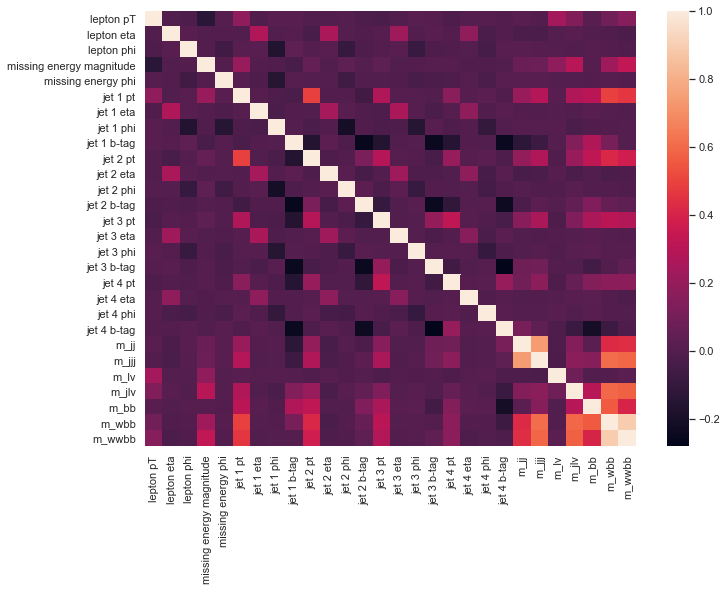

In [7]:
# 1.1
plt.figure(figsize=(11,8))
corrMat = data_train.iloc[:,0:28].corr()
sns.heatmap(corrMat)
plt.show()

##### Answer 1.1:  
The plot illustrates that the last 7 predictors (the one made by physicists) creates most  of the correlation. It makes sense that the predictors made by the physicists have correlation with the other predictors because they are derived based on the 21 first predictors. The correlation is highest within the predictors made by physicists (around 0.6) and that indicates that they are derived based on similar inputs. Other than this there is low correlation, while it seems to follow some form of pattern throughout.

**1.2** Fit a logistic regression model to predict `class` from all 28 of the predictors, and evaluate the model's accuracy on both the training and test sets.

In [8]:
logit = LogisticRegression(penalty="none", fit_intercept=True).fit(X_train, y_train)
print(f'The accuracy score on the train set is {accuracy_score(y_train, logit.predict(X_train))}.')
print(f'The accuracy score on the test set is {accuracy_score(y_test, logit.predict(X_test))}.')

The accuracy score on the train set is 0.6546.
The accuracy score on the test set is 0.6288.


**1.3** Fit a logistic regression model to predict `class` from all 28 of the predictors and all two-way interactions between these predictors (you should have $28+{28 \choose 2} = 406$ columns in the design matrix, ignoring the intercept).  Evaluate the model's accuracy on both the training and test sets.

Hint: you may have to scale your predictors (purely for numerical reasons) and use`maxiter=2000` to avoid the warnings (the next part as well).

In [9]:
# Adding all the two-way interaction terms:
transformer = PolynomialFeatures(2, interaction_only=True, include_bias=False)
transformer = transformer.fit(X_train)
expanded_train = transformer.transform(X_train)
expanded_test = transformer.transform(X_test)

# Standardizing the predictors:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(expanded_train) 
expanded_trainSTD = scaler.transform(expanded_train) 
expanded_testSTD = scaler.transform(expanded_test) 
logit_interact = LogisticRegression(penalty="none", fit_intercept=False, max_iter=2000)
logit_interact.fit(expanded_trainSTD, y_train)

print(f'The accuracy_score for the train with two-way interactions is: {accuracy_score(y_train, logit_interact.predict(expanded_trainSTD))}.')
print(f'The accuracy_score for the test set with two-way interactions i {accuracy_score(y_test, logit_interact.predict(expanded_testSTD))}.')

The accuracy_score for the train with two-way interactions is: 0.7122.
The accuracy_score for the test set with two-way interactions i 0.6314.


**1.4** Use 'L2' regularization on the model in the previous part, tuning the penalty term using 5-fold cross-validation (consider the set of Cs to be [0.01,0.1,1,10,100,1000]).  Which penalty term performed best?  Evaluate the best model's accuracy on both the training and test sets. 



In [10]:
from sklearn.linear_model import LogisticRegressionCV
logit_interactCV = LogisticRegressionCV(Cs=[0.01,0.1,1,10,100,1000], penalty='l2', cv=5, max_iter=2000)
logit_interactCV.fit(expanded_trainSTD, y_train)


LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10, 100, 1000], cv=5, max_iter=2000)

In [11]:
print(f'The penalty term that performed best was {logit_interactCV.C_[0]}')

logit_interact1 = LogisticRegression(C=0.1, fit_intercept=False, max_iter=2000)
logit_interact1.fit(expanded_trainSTD, y_train)
print(f'The test score with C=0.1 is {accuracy_score(y_train, logit_interact1.predict(expanded_trainSTD))}')
print(f'The test score with C=0.1 is {accuracy_score(y_test, logit_interact1.predict(expanded_testSTD))}')


The penalty term that performed best was 0.1
The test score with C=0.1 is 0.7
The test score with C=0.1 is 0.632


**1.5** Compare the performance of the 3 models above.  Which model performs the best on the train set?  Which the best on the test set?  Is this expected?

The final model including regularization does best on the test set, just marginally better than our model without regularization but with interaction terms, which does best on the train set. This makes sense since adding more predictors will lead to more fitting (and overfitting) to the train data set and thus a higher score on train. The test score confirms this overfitting. 

The model without interaction terms does worst, but is still only 0.0032 lower on the test set than our best scoring model.
One can argue that it is preferable to choose the simpler model in this case in order to choose a model that does almost as good with much fewer predictors and more interpretability.

---

<div class='exercise'><b>Question 2 [30 pts]: Tree and Forest Models </b></div>
Our first go to tree-based models, along with our first ensemble methods (bagging and random forests) which we played around with a bit on homework 4.

**2.1** Fit a decision tree model to the training set. Choose a range of tree depths from 1 to 20 and evaluate the  performance and standard deviations for each depth using 5-fold cross-validation. Plot the estimated mean +/- 2 standard deviations for each depth. Also, include the training set performance in your plot, but set the y-axis to focus on the cross-validation performance. 
Store the CV means and std variables `cvmeans`, `cvstds` and the train score `train_scores`  

*Hint*: use `plt.fill_between` to shade the region.

**2.2** Select an appropriate depth and justify your choice using your cross-validation estimates. Then report the classification accuracy on the **test set**. Store the training and test accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score` to refer to in a later question.

**2.3** Fit a Bagging model using the `X_train` data.  Tune (1) the tree depth from the depths of [5.10.15], and (2) the number of trees from the options [20,50,100].  Evaluate its accuracy on the train and test sets and assign it to variables named `bagging_train_score` and `bagging_test_score`.

**2.4** Fit a `RandomForestClassifier` using the original `X_train` data using the same tree depth and number of trees that you used in the previous question, but tune the number features to consider when looking for the best splits (consider from the list [5,10,15,20,25]). Evaluate its accuracy on the train and test sets and assign it to variables named `random_forest_train_score` and `random_forest_test_score`.

**2.5** Why should the bagging model be tuned to a `max_depth` that is at least as deep as the best single tree depth (from 2.2)?

**2.6**: If you were to run your code again for the bagging and random forest models, would you get the same results?  Why?


## Answers

**2.1** Fit a decision tree model to the training set. Choose a range of tree depths from 1 to 20 and evaluate the  performance and standard deviations for each depth using 5-fold cross-validation. Plot the estimated mean +/- 2 standard deviations for each depth. Also, include the training set performance in your plot, but set the y-axis to focus on the cross-validation performance. 
Store the CV means and std variables `cvmeans`, `cvstds` and the train score `train_scores`  

*Hint*: use `plt.fill_between` to shade the region.


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# getting scores, means and stds for all depths:
maxdepths = list(range(1, 21))
train_scores = []
cvmeans = []
cvstds = []
cvscores = []

for depth in maxdepths:
    dtree = DecisionTreeRegressor(max_depth=depth)
    train_scores.append(dtree.fit(X_train, y_train).score(X_train, y_train))
    scores = cross_val_score(estimator=dtree, X=X_train, y=y_train, cv=5)
    cvscores.append(scores)
    cvmeans.append(scores.mean())
    cvstds.append(scores.std())

cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

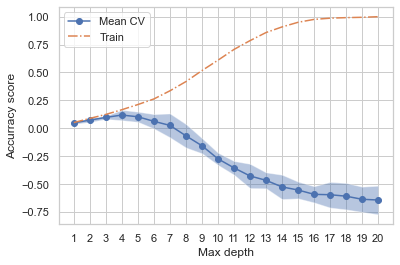

In [13]:
# plot:
plt.plot(maxdepths, cvmeans, 'o-', label="Mean CV")
plt.fill_between(maxdepths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.4)
plt.plot(maxdepths, train_scores, '-.', label="Train")
plt.legend()
plt.ylabel("Accurracy score")
plt.xlabel("Max depth")
plt.xticks(maxdepths);

**2.2** Select an appropriate depth and justify your choice using your cross-validation estimates. Then report the classification accuracy on the **test set**. Store the training and test accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score` to refer to in a later question.

In [14]:
# Choosing a max depth of 4 since this gives us the highest mean score from cross-validation.

dtree = DecisionTreeRegressor(max_depth=4)
best_cv_tree_train_score = dtree.fit(X_train, y_train).score(X_train, y_train)
best_cv_tree_test_score = dtree.fit(X_train, y_train).score(X_test, y_test)
print(f'For a max depth of 4 the train score is {best_cv_tree_train_score:.4}, and the test score is {best_cv_tree_test_score:.4}')

For a max depth of 4 the train score is 0.1666, and the test score is 0.1102


**2.3** Fit a Bagging model using the `X_train` data.  Tune (1) the tree depth from the depths of [5.10.15], and (2) the number of trees from the options [20,50,100].  Evaluate its accuracy on the train and test sets and assign it to variables named `bagging_train_score` and `bagging_test_score`.

In [24]:
# running Bagging with randomforest by setting max_features=1
from sklearn.model_selection import ParameterGrid

param_dict = {'max_depth': [5,10,15], 'n_estimators': [20, 50, 100]}
param_grid = ParameterGrid(param_dict)
clf = RandomForestClassifier(n_jobs=-1,
                               random_state=0,
                               max_features=None)
bagging_train_score = [0]
bagging_test_score = [0]
best_params={}
for params in param_grid:
    clf.set_params(**params)
    clf.fit(X_train, y_train)
    if accuracy_score(y_test, clf.predict(X_test)) > bagging_test_score:
        best_params = clf.get_params()
        bagging_train_score = accuracy_score(y_train, clf.predict(X_train))
        bagging_test_score = accuracy_score(y_test, clf.predict(X_test))

depth, trees = best_params['max_depth'], best_params['n_estimators']
print(f'The best score on the test set is {bagging_test_score}, with {trees} trees and depth {depth}')
best_params

The best score on the test set is 0.6866, with 100 trees and depth 10


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [ ]:
--


# detteer orginale bagging. prøver heller parameter grid først. slett:
from sklearn.utils import resample
ntrees = 200
estimators = []
R2s = []
yhats_test = np.zeros((X_test.shape[0], ntrees))
yhats_dummy = np.zeros((dummy_x.shape[0], ntrees))
plt.plot(elect_train['logminority'],y_train,'.')
for i in range(ntrees):
    simpletree = DecisionTreeRegressor(max_depth=10)  
    boot_x, boot_y = resample(X_train[['logminority']], y_train)   #Resampling
    estimators.append(simpletree.fit(boot_x, boot_y))
    R2s.append(simpletree.score(X_test[['logminority']], y_test))
    yhats_test[:,i] = simpletree.predict(X_test[['logminority']])
    yhats_dummy[:,i] = simpletree.predict(dummy_x.reshape(-1,1))
    plt.plot(dummy_x, simpletree.predict(dummy_x.reshape(-1,1)), 'red', alpha=0.02)
plt.plot(dummy_x,np.mean(yhats_dummy,axis=1),'black');

**2.4** Fit a `RandomForestClassifier` using the original `X_train` data using the same tree depth and number of trees that you used in the previous question, but tune the number features to consider when looking for the best splits (consider from the list [5,10,15,20,25]). Evaluate its accuracy on the train and test sets and assign it to variables named `random_forest_train_score` and `random_forest_test_score`.




In [20]:
from sklearn.model_selection import ParameterGrid

param_dict = {'max_features':[5,10,15,20,25]}
param_grid = ParameterGrid(param_dict)
clf = RandomForestClassifier(max_depth=15, n_estimators=100)
random_forest_train_score = [0]
random_forest_test_score = [0]
best_params={}
for params in param_grid:
    clf.set_params(**params)
    clf.fit(X_train, y_train)
    if accuracy_score(y_test, clf.predict(X_test)) > random_forest_test_score:
        best_params = clf.get_params()
        random_forest_train_score = accuracy_score(y_train, clf.predict(X_train))
        random_forest_test_score = accuracy_score(y_test, clf.predict(X_test))

bestFeature = best_params['max_features']
print(f'The best score on the test set is {random_forest_test_score}, with {bestFeature} as the best splitting number.')
best_params


The best score on the test set is 0.6922, with 25 as the best splitting number.


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 25,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

**2.5** Why should the bagging model be tuned to a `max_depth` that is at least as deep as the best single tree depth (from 2.2)?



##### Answer 2.5:
When doing bagging we want the model to be a little overfit, since the bagging process deals with this overfitting to make our model better. If we have a lower max depth than our best value for a single tree the model will be underfit and there is no reason to use bagging.

**2.6**: If you were to run your code again for the bagging and random forest models, would you get the same results?  Why?


##### Answer 2.6:
Since I am using random_state=0 I will get the same split each time I run the code. If I do not include random_state I will get a new result each time i run the code because the splits will be varying randomly each time. However, the result does not vary very much in quantity.

---

<div class='exercise'><b> Question 3 [30 pts]: Boosting </div>
In this question we explore a different kind of ensemble method, boosting, where each new model is trained on a dataset weighted towards observations that the current set of models predicts incorrectly. 

We'll focus on the AdaBoost flavor of boosting and examine what happens to the ensemble model's accuracy as the algorithm adds more estimators (iterations) to the ensemble.

**3.1** We'll motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. 
Report the train and test accuracies. For each predictor, make a plot that compares two distributions: the values of that predictor for examples that `tree1` classifies correctly, and the values of that predictor for examples that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?

*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.

**3.2** Use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree with `max_depth=3` as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.

**3.3** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)

**3.4** Based on the plot you just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?

**3.5** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

**3.6** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

## Answers

**3.1** We'll motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. 
Report the train and test accuracies. For each predictor, make a plot that compares two distributions: the values of that predictor for examples that `tree1` classifies correctly, and the values of that predictor for examples that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?

*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.

In [30]:
    # må høre om det er lov å bruke adaBoostclassifier på dette tidspunktet..
from sklearn.ensemble import AdaBoostClassifier
tree1 = AdaBoostClassifier( 
    base_estimator = DecisionTreeClassifier(max_depth = 3),
    algorithm = 'SAMME', 
#     n_estimators=100, 
#     learning_rate=0.01
)

tree1.fit(X_train,y_train)

print(f'The train score for tree1 is {accuracy_score(y_train, tree1.predict(X_train))}')
print(f'The test score for tree1 is {accuracy_score(y_test, tree1.predict(X_test))}')

The train score for tree1 is 0.7464
The test score for tree1 is 0.688


ValueError: X has 2 features, but DecisionTreeClassifier is expecting 28 features as input.

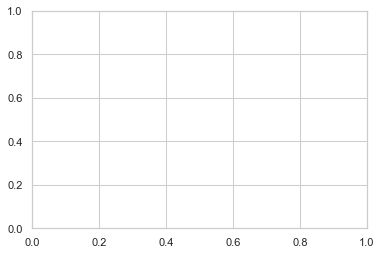

In [54]:
# For each predictor, make a plot that compares two distributions: the values of that predictor for examples that 
# tree1 classifies correctly, and the values of that predictor for examples that tree1 classifies incorrectly. 
#Do you notice any predictors for which the distributions are clearly different?
# Hints:
# If you have fig, axs = plt.subplots(...), then axs.ravel() gives a list of each plot in reading order.
# sns.kdeplot takes ax and label parameters.
N=100
fig, ax = plt.subplots()

x_min, x_max = X_test[:, 0].min() , X_test[:, 0].max()
y_min, y_max = X_test[:, 1].min() , X_test[:, 1].max()
xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))
Z = tree1.predict(np.c_[xx.ravel(), yy.ravel()])  #for å få mesh format på det.
# sns.kdeplot(Z[:, 0, 0])
# ax.contourf(xx, yy, Z,cmap=cmap,alpha=0.4)
# ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights * 40, edgecolors='k',label = f'Stump {counter}')
# ax.legend(fontsize=16)

*Your answer here*



**3.2** Use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree with `max_depth=3` as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.



In [ ]:
from sklearn.ensemble import AdaBoostClassifier
tree2 = AdaBoostClassifier( 
    base_estimator = DecisionTreeClassifier(max_depth = 3),
    algorithm = 'SAMME', 
    n_estimators=800, 
    learning_rate=0.05
)

tree2.fit(X_train,y_train)

print(f'The train score for tree2 is {accuracy_score(y_train, tree2.predict(X_train))}')
print(f'The test score for tree2 is {accuracy_score(y_test, tree2.predict(X_test))}')

    # MAKE PLOT ALSO...


In [ ]:
staged_scores(X_train, y_train)

**3.3** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)



In [ ]:
######
# your code here
######

*Your answer here*



**3.4** Based on the plot you just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?



In [ ]:
######
# your code here
######

*Your answer here*


**3.5** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

*your answer here*

**3.6** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

*your answer here*

---

<div class='exercise'> <b> Question 4 [15 pts]: Model Comparison </b> </div>


**4.1**: Make a pandas table of the training and test accuracy for the following 5 models and name it `results_df`:

- The tuned L2-regularized logistic regression (from Question 1)
- Single tree with best depth chosen by cross-validation (from Question 2)
- Your tuned bagging model (from Question 2)
- Your tuned random forest model  (from Question 2)
- Your tuned adaBoost model  (from Question 3)

(see below for the expected structure)  

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.


**4.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?


**4.3** Which of these techniques can be extended to regression tasks? How?

## Answers

**4.1**: Make a pandas table of the training and test accuracy for the following 6 models and name it `results_df`:

- The full logistic regression (from Question 1.3)
- The tuned L2-regularized logistic regression (from Question 1.4)
- Single tree with best depth chosen by cross-validation (from Question 2)
- Your tuned bagging model (from Question 2)
- Your tuned random forest model  (from Question 2)
- Your tuned adaBoost model  (from Question 3)

(see below for the expected structure)  

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

---

Fill in the following table.


| classifier | training accuracy | test accuracy |
| --- | --- | --- |
| logistic  | | |
| regularized logistic  | | |
| single tree  | | |
| bagging | | |
| random forest  | | |
| adaboost  | | |

In [59]:
# The tuned L2-regularized logistic regression (from Question 1)
# Single tree with best depth chosen by cross-validation (from Question 2)
# Your tuned bagging model (from Question 2)
# Your tuned random forest model (from Question 2)
# Your tuned adaBoost model (from Question 3)

# # Logistic from all 28 of the predictors:
# print(f'{accuracy_score(y_train, logit.predict(X_train))}')
# print(f'{accuracy_score(y_test, logit.predict(X_test))}')
# # with interaction terms:
# print(f'The accuracy_score for the train with two-way interactions is: {accuracy_score(y_train, logit_interact.predict(expanded_trainSTD))}.')
# print(f'The accuracy_score for the test set with two-way interactions i {accuracy_score(y_test, logit_interact.predict(expanded_testSTD))}.')
# with l2 regularization C=0.1:
print(f'The test score with C=0.1 is {accuracy_score(y_train, logit_interact1.predict(expanded_trainSTD))}')
print(f'The test score with C=0.1 is {accuracy_score(y_test, logit_interact1.predict(expanded_testSTD))}')

    # oppgave 2:
print(f'For a max depth of 4 the train score is {best_cv_tree_train_score:.4}, and the test score is {best_cv_tree_test_score:.4}')

# running Bagging with randomforest by setting max_features=1:
print(f'The best score on the test set is {bagging_test_score}, with {trees} trees and depth {depth}')

# RandomForestClassifier:
print(f'The best score on the test set is {random_forest_test_score}, with {bestFeature} as the best splitting number.')

    #oppgave 3:
# adaboost:
# print(f'The train score for tree1 is {accuracy_score(y_train, tree1.predict(X_train))}')
# print(f'The test score for tree1 is {accuracy_score(y_test, tree1.predict(X_test))}')
# with more inputs:
print(f'The train score for tree2 is {accuracy_score(y_train, tree2.predict(X_train))}')
print(f'The test score for tree2 is {accuracy_score(y_test, tree2.predict(X_test))}')

0.6546
0.6288
The accuracy_score for the train with two-way interactions is: 0.7122.
The accuracy_score for the test set with two-way interactions i 0.6314.
The test score with C=0.1 is 0.7
The test score with C=0.1 is 0.632
For a max depth of 4 the train score is 0.1666, and the test score is 0.1102
The best score on the test set is 0.6866, with 100 trees and depth 10
The best score on the test set is 0.6922, with 25 as the best splitting number.
The train score for tree1 is 0.7464
The test score for tree1 is 0.688


In [ ]:

pd.DataFrame([
    
])

*Your answer here*



**4.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?



*Your answer here*


**4.3** Which of these techniques can be extended to regression tasks? How?


*Your answer here*